In [37]:
import requests
from pathlib import Path
import os 
import sys
import torch
from torch import nn
import pandas as pd
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
import mlxtend

In [38]:
print(f"Pytorch version: {torch.__version__} \nTorchvision version: {torchvision.__version__}")

Pytorch version: 2.8.0+cpu 
Torchvision version: 0.23.0+cpu


#### Getting github file 

In [39]:
if Path("../helper_functions.py").is_file():
    print("Helper functions file already exists, skipping download...")
else:
    print("Dowloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
    )
    with open("../src/helper_functions.py", "wb") as f:

        f.write(request.content)

Dowloading helper_functions.py


#### Getting data

In [40]:
# Setup training dataset
train_data = datasets.FashionMNIST(
    root="data", # Where the data is going to be downloaded
    train=True, # If the dataset is going to be the training or the testing one
    download=True, # Dowload the data if it doesnt exists on the disk
    transform=ToTensor(), # Images come as PIL format, we want to turn into torch.Tensor
    target_transform=None # Transform the labels aswell
)
# Setup testing dataset
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

##### Visualize data example

In [41]:
image, label = train_data[0]
print(f"Train image example: {image}")
print("-" * 90)
print(f"Train image shape: {image.shape}")
print(f"Image label: {label}")
print("-" * 90)
print(f"Dataset format - Train: {len(train_data.data)}, {len(train_data.targets)} | Test: {len(test_data.data)}, {len(test_data.targets)}")

Train image example: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.

In [42]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

##### Visualazing our data

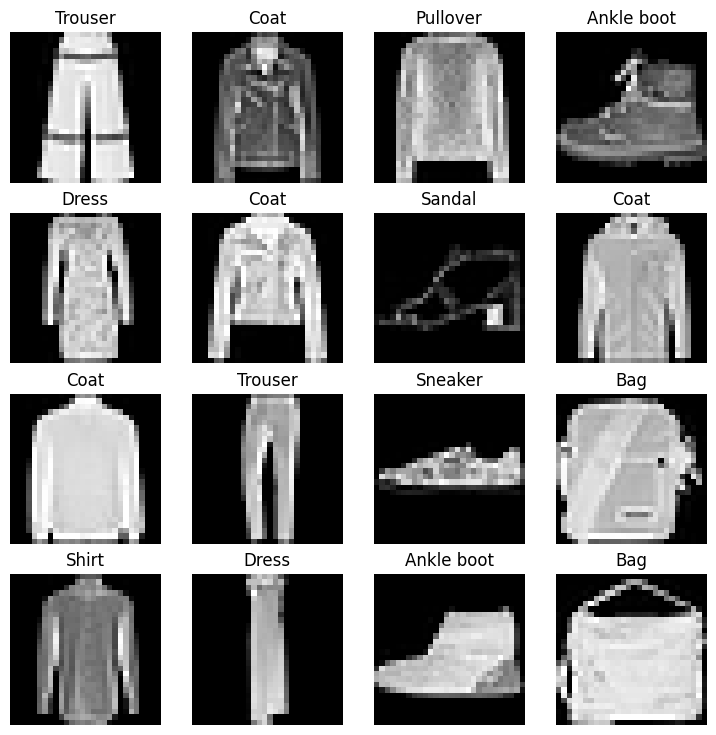

In [43]:
def plot_img(train_data,):
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4
    for i in range(1, rows * cols + 1):
        random_idx = torch.randint(0, len(train_data), size=[1]).item()
        img, label = train_data[random_idx]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis(False)
    plt.show()

plot_img(train_data)


##### Creating data loader

In [44]:
from torch.utils.data import DataLoader

# Setup the batch size
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader= DataLoader(train_data, #Dataset to turn into iterable
                             batch_size=BATCH_SIZE, # len(train_data) / batch_size = how many samples per batch
                             shuffle=True # If it will shuffle data every epoch
                             )
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001BD4776C460>, <torch.utils.data.dataloader.DataLoader object at 0x000001BD44BB7580>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [45]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [46]:
# Create a flatten layer
flatten_model = (
    nn.Flatten()
)  # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)  # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


#### Create model

In [47]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    def forward(self, x):
        return self.layer_stack(x)

In [48]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, hidden_units=10, output_shape=len(class_names)
)
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [49]:
loss_fn = nn.CrossEntropyLoss()
optm = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [50]:
from timeit import default_timer as Timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time.
       Use code:
                start_time = timer()
                some code...
                end_time = timer()
                print_train_time(start_time, end_time, device)
    """
    
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


In [51]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


#### Training and test loop on batches of data

In [52]:
# Import tqdm for progress bar
from tqdm import tqdm
import time

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start = time.time()

# Set the number of epochs that my model is going to train on
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    training_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        # 1. Forward pass
        y_pred = model_0(X)
        # Calculate the loss
        loss = loss_fn(y_pred, y)
        #2. Optm zero grad
        optm.zero_grad()
        #3. Loss backward 
        loss.backward()
        #4. Optm step
        optm.step()
        
        #5. Print out whats happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
    # Divide total train loss by length of train dataloader
    training_loss /= len(train_dataloader)
    
    ### Testing
    model_0.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)
            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y_test)
            # 3. Calculate the accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {training_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end = time.time()
total_train_time = print_train_time(train_time_start, train_time_end, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:04<00:09,  4.66s/it]


Train loss: 0.0000 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:08<00:04,  4.43s/it]


Train loss: 0.0000 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
-------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:12<00:00,  4.33s/it]


Train loss: 0.0000 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 13.001 seconds


In [53]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.4766),
 'model_acc': 83.42651757188499}

#### Save model

In [54]:
MODEL_PATH = Path("models")
MODEL_NAME = "01_pytorch_computervision_workflow_model_00.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Salvando model em {MODEL_SAVE_PATH}")
torch.save(obj=model_0, f=MODEL_SAVE_PATH)

Salvando model em models\01_pytorch_computervision_workflow_model_00.pth


#### Model 2: Building a convolutional neural network

##### Explaning features:
 1. Kernel_size: size of the filter that is going to pass on our image
 2. Stride: how many pixels its going to move per block to form our final matrix
 3. Padding: how many out layers of zeros our image is going to have

In [55]:
class FashionMNISTModelV1(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.convblock_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.convblock_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor) :
        x = self.convblock_1(x)
        #print(x.shape)
        x = self.convblock_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x        

In [56]:
model_1 = FashionMNISTModelV1(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))
model_1

FashionMNISTModelV1(
  (convblock_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [58]:
loss_fn = nn.CrossEntropyLoss()
optm = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

#### Creating training and testing functions

In [59]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),  # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


#### Training and testing the model

In [60]:
from timeit import default_timer as timer
train_time_start_model_1 = timer()

# Train and test the model
epochs = 10
for epoch in tqdm(range(epochs), desc="Training and testing model..."):
    print(f"Epoch: {epoch}\n---------------")
    train_step(model_1, train_dataloader, loss_fn, optm, accuracy_fn, device)
    test_step(test_dataloader, model_1, loss_fn, accuracy_fn, device)
train_time_end_model_1 = timer()
total_train_time = print_train_time(start=train_time_end_model_1, end=train_time_start_model_1, device=device)

Training and testing model...:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------------
Train loss: 0.58921 | Train accuracy: 78.44%


Training and testing model...:  10%|█         | 1/10 [00:13<02:05, 13.99s/it]

Test loss: 0.39194 | Test accuracy: 86.07%

Epoch: 1
---------------
Train loss: 0.35345 | Train accuracy: 87.32%


Training and testing model...:  20%|██        | 2/10 [00:27<01:51, 13.94s/it]

Test loss: 0.37081 | Test accuracy: 86.65%

Epoch: 2
---------------
Train loss: 0.31518 | Train accuracy: 88.72%


Training and testing model...:  30%|███       | 3/10 [00:42<01:39, 14.20s/it]

Test loss: 0.34122 | Test accuracy: 87.97%

Epoch: 3
---------------
Train loss: 0.29571 | Train accuracy: 89.28%


Training and testing model...:  40%|████      | 4/10 [00:57<01:26, 14.39s/it]

Test loss: 0.31643 | Test accuracy: 88.36%

Epoch: 4
---------------
Train loss: 0.28216 | Train accuracy: 89.84%


Training and testing model...:  50%|█████     | 5/10 [01:11<01:12, 14.55s/it]

Test loss: 0.31132 | Test accuracy: 88.91%

Epoch: 5
---------------
Train loss: 0.27305 | Train accuracy: 90.06%


Training and testing model...:  60%|██████    | 6/10 [01:26<00:58, 14.58s/it]

Test loss: 0.31080 | Test accuracy: 88.63%

Epoch: 6
---------------
Train loss: 0.26508 | Train accuracy: 90.33%


Training and testing model...:  70%|███████   | 7/10 [01:40<00:42, 14.33s/it]

Test loss: 0.29749 | Test accuracy: 89.11%

Epoch: 7
---------------
Train loss: 0.25859 | Train accuracy: 90.54%


Training and testing model...:  80%|████████  | 8/10 [01:53<00:28, 14.08s/it]

Test loss: 0.30831 | Test accuracy: 88.82%

Epoch: 8
---------------
Train loss: 0.25617 | Train accuracy: 90.59%


Training and testing model...:  90%|█████████ | 9/10 [02:07<00:13, 13.90s/it]

Test loss: 0.30178 | Test accuracy: 88.85%

Epoch: 9
---------------
Train loss: 0.24966 | Train accuracy: 90.80%


Training and testing model...: 100%|██████████| 10/10 [02:20<00:00, 14.10s/it]

Test loss: 0.29124 | Test accuracy: 89.40%

Train time on cpu: -140.997 seconds


In [61]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': tensor(0.2912),
 'model_acc': 89.39696485623003}

#### Making predictions

In [62]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(
                device
            )  # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit.squeeze(), dim=0
            )  # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [85]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(
    f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})"
)

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [86]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=model_1, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3])

In [87]:
for sample in test_samples:
    print(sample.squeeze().shape)
    break

torch.Size([28, 28])


#### Visualize predictions

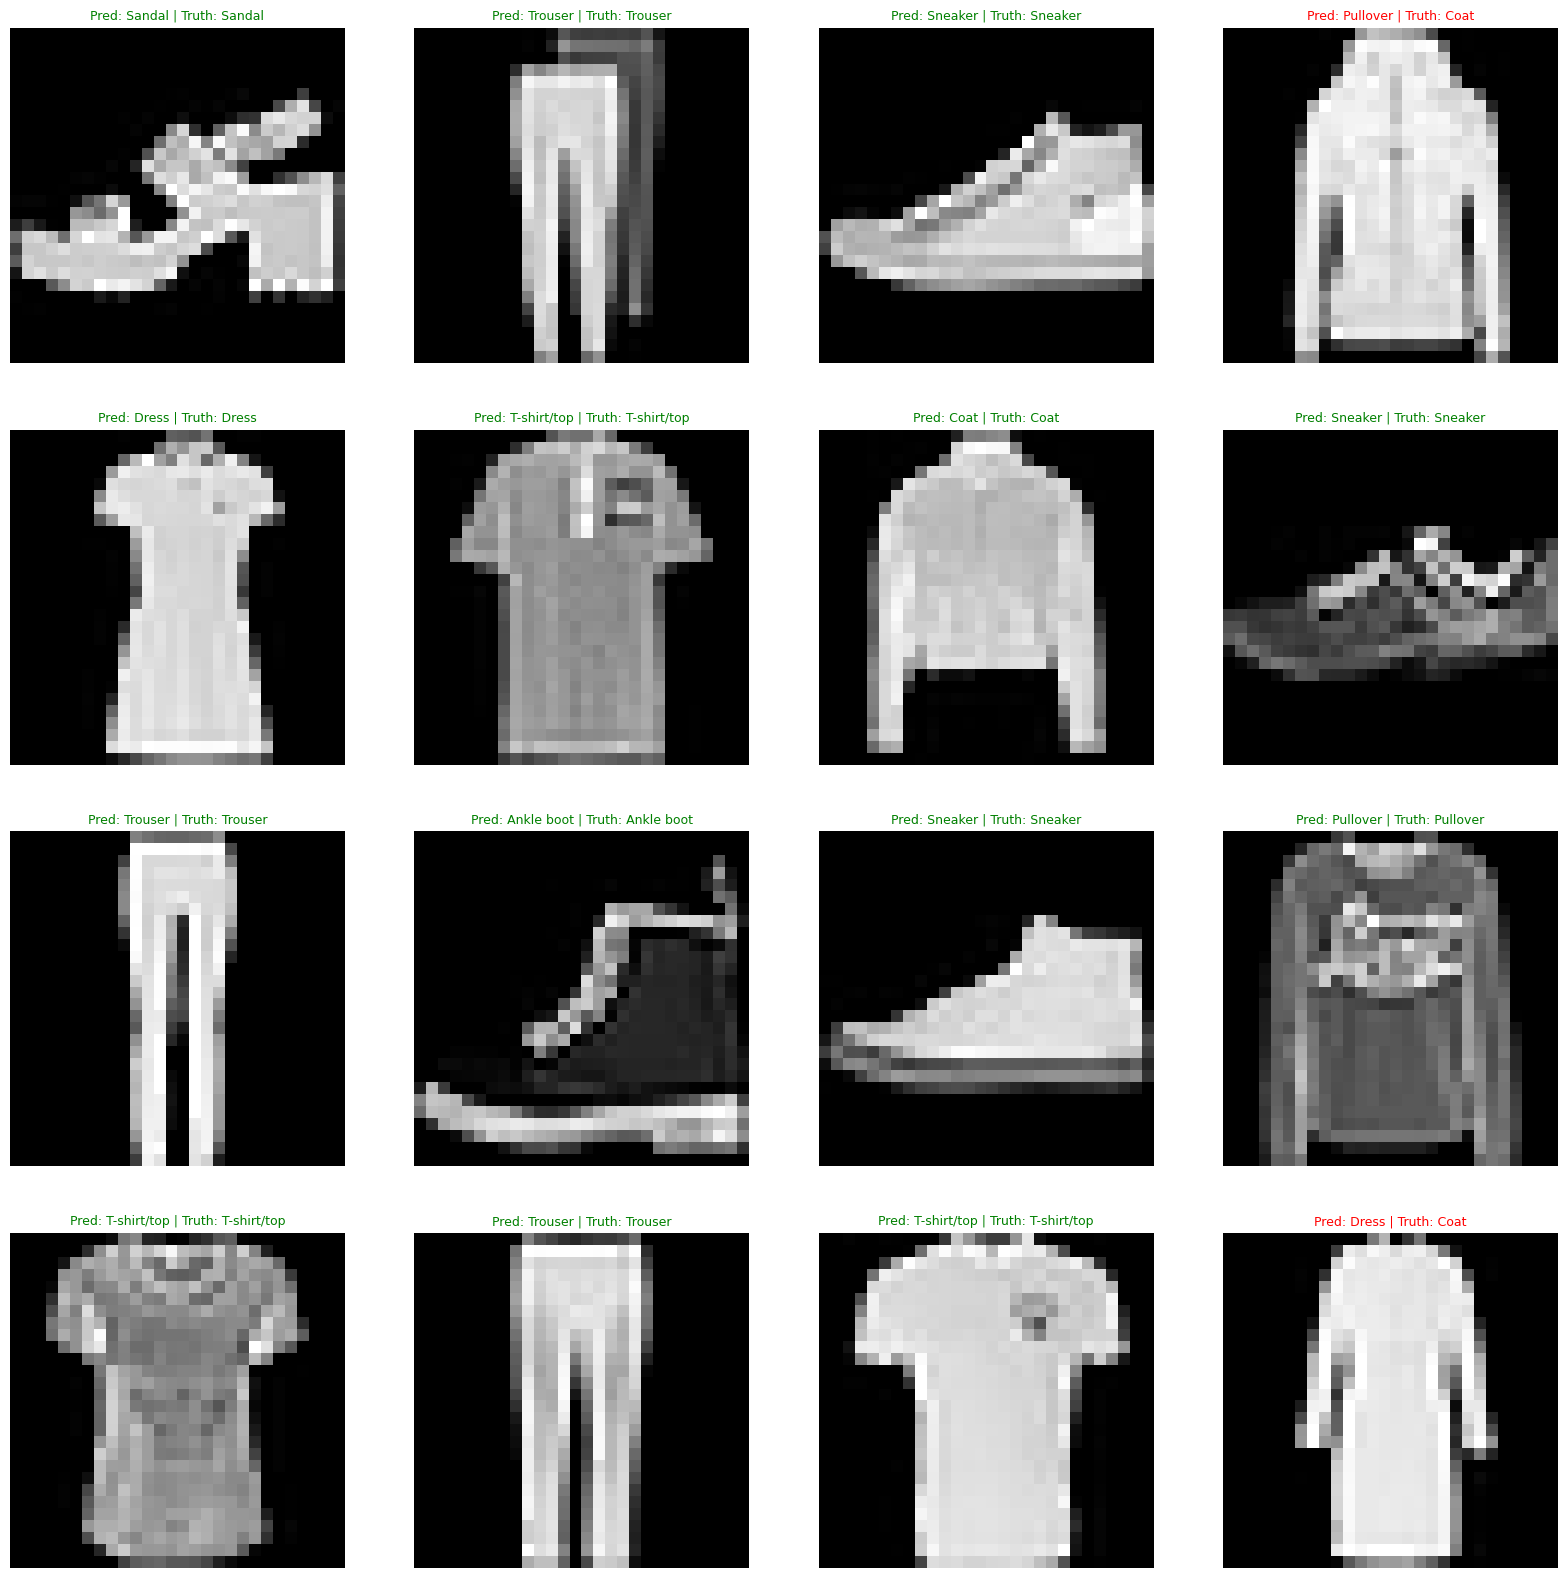

In [88]:
nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))
axs = axs.ravel()
for i, sample in enumerate(test_samples):
    axs[i].imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    axs[i].set_title(title_text, fontsize=9, color="g" if pred_label == truth_label else "r")
    axs[i].axis("off")


#### Making a confusion matrix


In [89]:
y_preds = []
model_1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_1(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 261.38it/s]


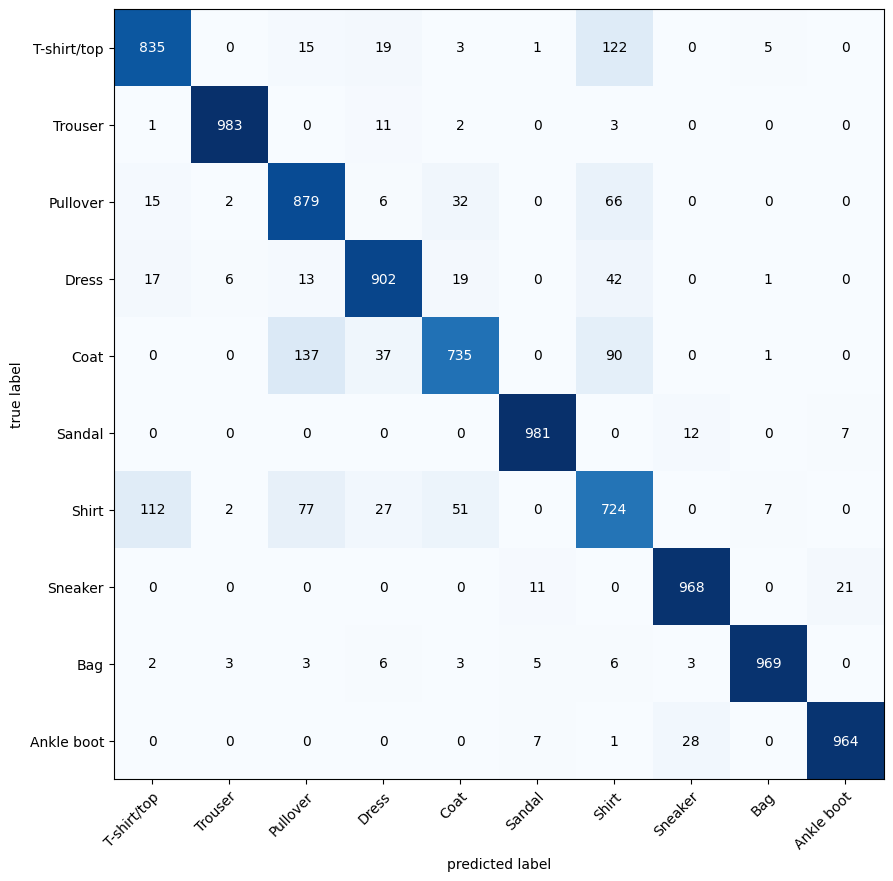

In [92]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,10)
)

#### SAVE MODEL


In [94]:
MODEL_NAME = "02_pytorch_computervision_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving the model in {MODEL_SAVE_PATH}")
torch.save(obj=model_1, f=MODEL_SAVE_PATH)

Saving the model in models\02_pytorch_computervision_workflow_model.pth
